In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import torchaudio.transforms as T
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
import librosa
import numpy as np
import pandas as pd

In [113]:
Drum_Kit_Sound_Samples_annotations = "data/Drum_Kit_Sound_Samples/annotations.csv"
SAMPLE_RATE=22050

In [144]:
class Drum_Kit_Sound_Samples(Dataset):
    def __init__(self, annotations_file, transform_option='MFCC'):
        self.annotations = pd.read_csv(annotations_file)
        
        if transform_option == 'MFCC':
            self.transform = T.MFCC(
                sample_rate=SAMPLE_RATE,
                n_mfcc=20,
                melkwargs={"n_fft": 1024, "hop_length": 256, "n_mels": 84}
            )
        elif transform_option == 'CQT':
            self.transform = T.CQT(
                sample_rate=SAMPLE_RATE,
                n_bins=128,
                hop_length=256
            )
        else:
            raise ValueError("Invalid transform option. Choose 'MFCC' or 'CQT'.")

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        signal, sr = torchaudio.load(audio_sample_path)

        spectrograms = []
        for channel in range(signal.shape[0]):
            spectrograms.append(self.transform(signal[channel, :]))

        spectrograms = torch.stack(spectrograms)

        return signal, spectrograms

    def _get_audio_sample_path(self, index):
        path = self.annotations.iloc[index, 0]
        return path

In [145]:
drum_kit_dataset = Drum_Kit_Sound_Samples(Drum_Kit_Sound_Samples_annotations)

# train_set,test_set = random_split(drum_kit_dataset, [128, 32])


In [156]:
sig, spec = drum_kit_dataset[2]

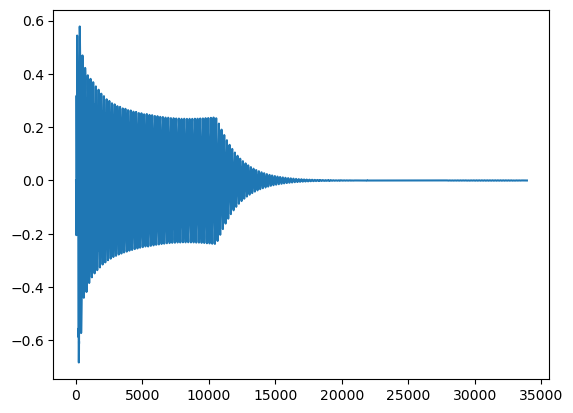

In [153]:
plt.plot(sig[0])

In [157]:
spec.shape

torch.Size([1, 20, 74])

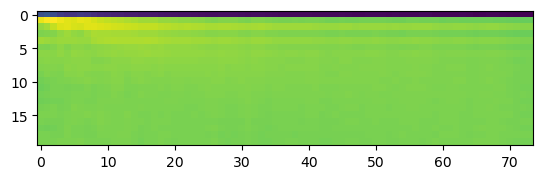

In [158]:
plt.imshow(spec[0])

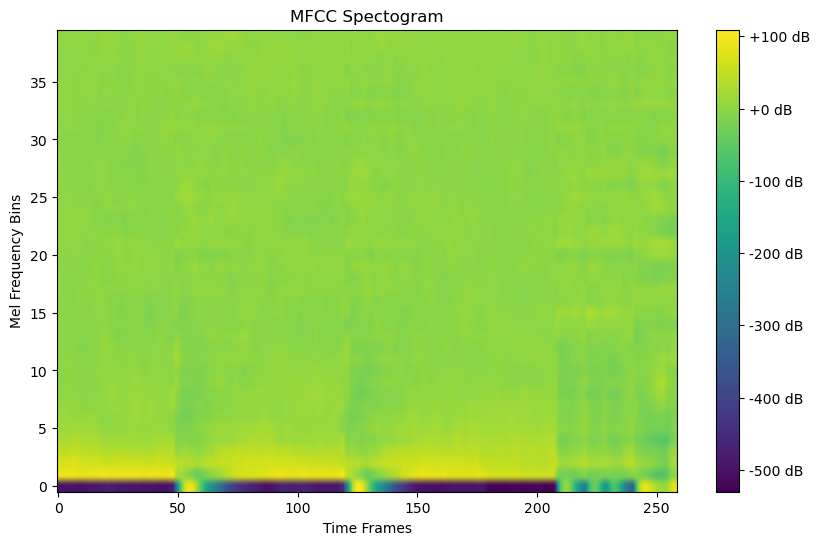

In [141]:
def plot_spectrogram(spectrogram):
    spectrogram = spectrogram.squeeze(0).numpy()  

    plt.figure(figsize=(10, 6))
    plt.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')
    plt.title("MFCC Spectogram")
    plt.ylabel("Mel Frequency Bins")
    plt.xlabel("Time Frames")
    plt.colorbar(format="%+2.0f dB")
    plt.show()
    
    
plot_spectrogram(spec[0])

In [42]:
class AutoEncoder(nn.module):
    def __init__(self):
        # N, 2, 64
    
    def forward(x):
        pass
    
    

4

In [273]:
audio, sr = librosa.load("data/Drum_Kit_Sound_Samples/toms/Tom Sample 1.wav", mono=False, sr=44100)

In [285]:
stft = librosa.stft(
    y=audio,
    n_fft=4096,         # FFT window size for better frequency resolution
    hop_length=512,    # Hop length
    win_length=4096,    # Window length (typically same as n_fft)
    window='hann',      # Hann window to reduce spectral leakage
    center=True,        # Center the frames
    pad_mode='reflect'  # Edge padding
)
stft_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max) 

# Compute mel spectrogram
S = librosa.feature.melspectrogram(
    y=audio,
    sr=sr,
    n_fft=4096,        # Larger FFT for better frequency resolution
    hop_length=1024,   # Larger hop length for non-speech sounds
    n_mels=256,        # More Mel bands for richer harmonic content
    fmin=20,           # Include sub-bass and environmental sounds
    fmax=sr / 2,       # Maximum frequency based on Nyquist limit
    power=2.0          # Power spectrogram
)

S /= np.max(S)  # Normalize to [0, 1]
log_S = librosa.power_to_db(S, ref=np.max)

mfccs = librosa.feature.mfcc(
    S=log_S,           
    sr=sr,
    n_mfcc=22,         
    dct_type=2,       
    norm='ortho',     
    lifter=60          
)

cqt = librosa.cqt(audio, sr=sr, hop_length=512)
cqt_db = librosa.amplitude_to_db(np.abs(cqt), ref=np.max)

In [286]:
print(mfccs.min())

-3261.8716


In [279]:
print(log_S.shape)
print(mfccs.shape)
print(stft_db.shape)
print(cqt_db.shape)

(2, 256, 87)
(2, 64, 87)
(2, 2049, 173)
(2, 84, 173)


## Plotting stuff

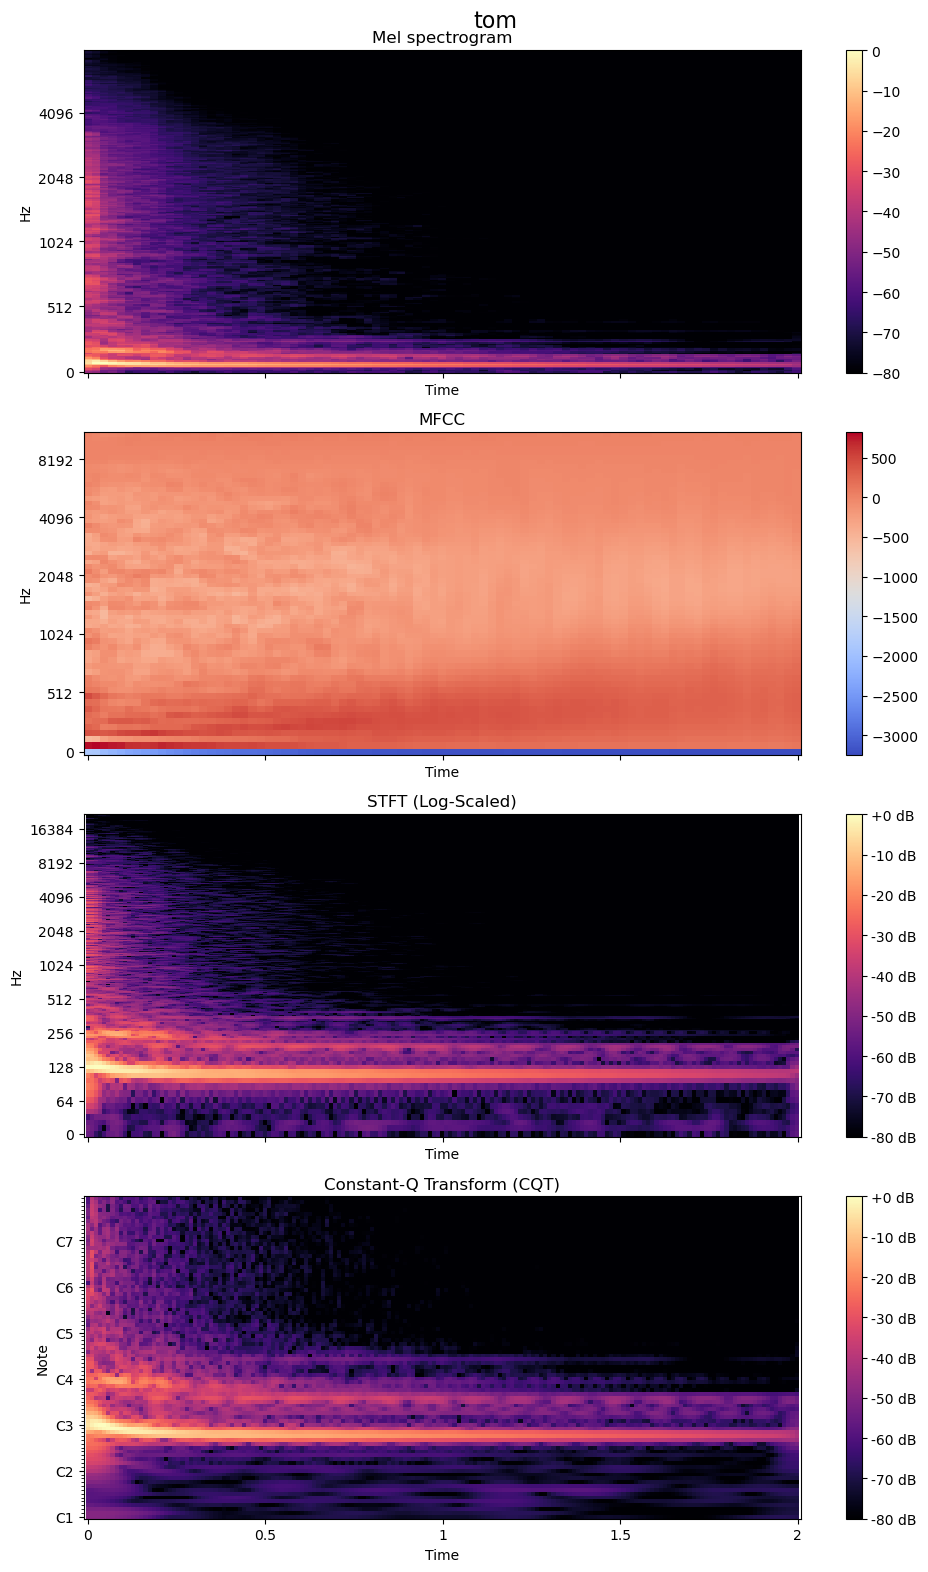

In [280]:
fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(10, 16))
img1 = librosa.display.specshow(log_S[0],
                               x_axis='time', 
                               y_axis='mel', 
                               fmax=8000,
                               ax=ax[0])
fig.colorbar(img1, ax=ax[0])

ax[0].set(title='Mel spectrogram')
ax[0].label_outer()

img2 = librosa.display.specshow(mfccs[0],
                               x_axis='time',
                               y_axis="mel",
                               ax=ax[1])
fig.colorbar(img2, ax=ax[1])
ax[1].set(title='MFCC')

# Plot STFT
img3 = librosa.display.specshow(
    stft_db[0], 
    sr=sr, 
    x_axis='time', 
    y_axis='log', 
    ax=ax[2]
)
fig.colorbar(img3, ax=ax[2], format='%+2.0f dB')
ax[2].set(title='STFT (Log-Scaled)')



# Plot CQT
img4 = librosa.display.specshow(
    cqt_db[0], 
    sr=sr, 
    x_axis='time', 
    y_axis='cqt_note', 
    ax=ax[3]
)
fig.colorbar(img4, ax=ax[3], format='%+2.0f dB')
ax[3].set(title='Constant-Q Transform (CQT)')

fig.suptitle('tom', fontsize=16)
plt.tight_layout()
output_file = "audio_analysis_tom.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()